(1, 512, 512, 31)


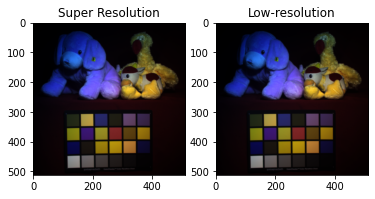

(<AxesSubplot:title={'center':'Low-resolution'}>,
 Text(0.5, 1.0, 'Low-resolution'),
 None)

In [13]:
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt
from MAIN import *
import os
import os.path as path

os.environ["CUDA_VISIBLE_DEVICES"]= '0'
Hy = scipy.io.loadmat('Data_set/stuffed_toys_ms.mat')['hyperimg']
Hy = Hy/np.max(Hy)

[m,n,l] = Hy.shape
Hy = tf.expand_dims(tf.convert_to_tensor(Hy),0)
print(Hy.shape)


Sup_Fact =1
RGB_bands = [30, 24, 5]

Hy = Hy.numpy()
most = np.squeeze(Hy)[:,:,RGB_bands]
plt.subplot(1,2,1),plt.imshow(most), plt.title('Super Resolution')

def Desimation_Super(x,factor,w):
    Aux = tf.image.resize(x,[int(np.round(w/factor)),int(np.round(w/factor))],method=tf.image.ResizeMethod.BICUBIC)
    return Aux

y = Desimation_Super(Hy,Sup_Fact,m)
pp = np.squeeze(y)
pp = pp[:,:,RGB_bands]
plt.subplot(1,2,2),plt.imshow(pp), plt.title('Low-resolution'),plt.show()

In [14]:
def LMM_Net_reconstruction(pretrained_weights=None, input_size = (150,150,1), L=102, rank = 8,Layer_depth=16,number_layer=4,initial=None, decimation=2):
    inputs = Input(input_size)
    drop1 = Dropout(0.2)(inputs)
    # block 1
    Ab = Abund_net_autoencoder(drop1,rank,name='1',L=Layer_depth,number_layer=number_layer)
    hy = Endmemebers_Layer(L=L, rank=rank,initicial=initial,name='estimation_1')(Ab)

    # block 2
    Ab2 = Abund_net_autoencoder(hy,rank,name='2',L=Layer_depth,number_layer=number_layer)
    hy2 = Endmemebers_Layer(L=L, rank=rank,initicial=initial,name='estimation_2')(Ab2)

    # block 3
    Ab3 = Abund_net_autoencoder(hy2,rank,name='_last',L=Layer_depth,number_layer=number_layer)
    hy3 = Endmemebers_Layer(L=L, rank=rank,initicial=initial,name='estimation_3')(Ab3)


    final =Lambda(lambda x: Desimation_Super(x,decimation,input_size[0])) (hy2)
    final2 =Lambda(lambda x: Desimation_Super(x,decimation,input_size[0])) (hy)
    final3 =Lambda(lambda x: Desimation_Super(x,decimation,input_size[0])) (hy3)



    model = Model(inputs, [final,final2,final3,Ab,Ab2,Ab3])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model


losses=['mean_squared_error','mean_squared_error','mean_squared_error', Abundance_loss(),Abundance_loss(),Abundance_loss()]

ouput_net = [y,y,y,np.ones((1,m,n)),np.ones((1,m,n)),np.ones((1,m,n))]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


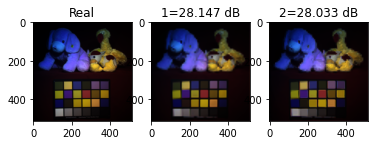

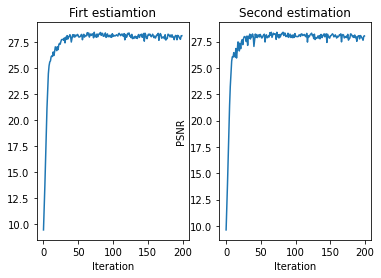

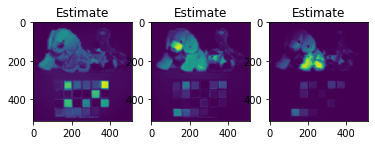

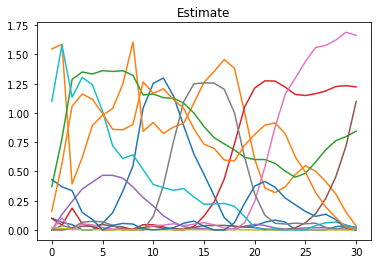

In [15]:
#-----------------Entrenamiento -----------------------------------------------
# important parameters

lay_Depth = 32
Num_lay  = 6
lr = 1e-3
pertu  = 0
losses_weight = [1,1,1,0.5,0.5,0.5]

for Sup_Fact in [2,4,8]:
    y = Desimation_Super(Hy,Sup_Fact,m)
    ouput_net = [y,y,y,np.ones((1,m,n)),np.ones((1,m,n)),np.ones((1,m,n))]
    for experiments in [1,2,3,4,5]:
        rank_Val = 12
        Path = 'Results_cave'
        try:
          os.stat(Path)
        except:
          os.mkdir(Path)
        Info_path = 'Factor_'+str(Sup_Fact)+'_V_'+str(experiments)
        Real_path = (Path+'/'+Info_path)
        try:
          os.stat(Real_path)
        except:
          os.mkdir(Real_path)


        model = LMM_Net_reconstruction(input_size =(m,n,l), L=l,rank=rank_Val,Layer_depth=lay_Depth,number_layer=Num_lay,decimation=Sup_Fact)
         # Optimization parameters
        optimizad = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=0.9,beta_2=0.9, amsgrad=False);
        model.compile(optimizer=optimizad, loss=losses,loss_weights=losses_weight)

        Global_max_epoch = 200
        contad_decr = 0
        psnr_deep_1 = []
        psnr_deep_2 = []
        psnr_deep_3 = []

        best_psnr= 0
        Input_v = tf.image.resize(y, [m, n]).numpy()
        for i in range(Global_max_epoch):
            print('Iteration = ' + str(i)+' of max= '+str(Global_max_epoch) +'\n')
            input_ent = Input_v + pertu*np.random.normal(0,1,(1,m,n,l))

            model.fit(input_ent, ouput_net, epochs = 100,batch_size=1,verbose=0)
            clear_output(wait=True)
                                # ouputs Models
            temporal = model.get_weights()
            Endm = np.squeeze(temporal[-1]) # aca cambio
            H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final_last').output])
                                #Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
            Image_recon = K.function([model.layers[0].input], [model.get_layer('estimation_1').output])
            Img_recon_1 = np.squeeze(np.asarray(Image_recon(input_ent)))
            rest_h_1 = np.squeeze(np.asarray(H_high(input_ent)))

            Image_recon = K.function([model.layers[0].input], [model.get_layer('estimation_2').output])
            Img_recon_2 = np.squeeze(np.asarray(Image_recon(input_ent)))
            rest_h_2 = np.squeeze(np.asarray(H_high(input_ent)))

            Image_recon = K.function([model.layers[0].input], [model.get_layer('estimation_3').output])
            Img_recon_3 = np.squeeze(np.asarray(Image_recon(input_ent)))


                                # evaluation model
            psnr_deep_1.append(psnr(np.squeeze(Hy), Img_recon_1))
            psnr_deep_2.append(psnr(np.squeeze(Hy), Img_recon_2))
            psnr_deep_3.append(psnr(np.squeeze(Hy), Img_recon_3))


            if(best_psnr>=psnr_deep_1[-1]):
                contad_decr +=1
            else:
                best_psnr = psnr_deep_1[-1]
                best_Endm = Endm
                best_Abun = rest_h_1
                best_img_1  = Img_recon_1
                best_img_2  = Img_recon_2
                best_img_3  = Img_recon_3


                contad_decr = 0
                scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img_1,'Img_recon2':best_img_2, 'Img_recon3':best_img_3,'PSNR':best_psnr})
                print('PNSR = '+ str(psnr_deep_1[-1])+ ', contador_decr= ' + str(contad_decr)+ ', best= ' + str(best_psnr)+'\n')


            pp = Img_recon_1 [:, :, RGB_bands]
            plt.subplot(1, 3, 1), plt.imshow(most), plt.title('Real')
            plt.subplot(1, 3, 2), plt.imshow(pp), plt.title('1=' + str(psnr_deep_1 [-1]) [0:6] + ' dB')
            pp = Img_recon_3 [:, :, RGB_bands]
            plt.subplot(1, 3, 3), plt.imshow(pp), plt.title('2=' + str(psnr_deep_2 [-1]) [0:6] + ' dB')
            plt.show()
            plt.subplot(1, 2, 1),plt.plot(psnr_deep_1), plt.title('Firt estiamtion'), plt.xlabel('Iteration'),
            plt.subplot(1, 2, 2),plt.plot(psnr_deep_2), plt.title('Second estimation'), plt.xlabel('Iteration'),
            plt.ylabel('PSNR'), plt.show()
            plt.subplot(1, 3, 1), plt.imshow(rest_h_1 [:, :, 0]), plt.title('Estimate')
            plt.subplot(1, 3, 2), plt.imshow(rest_h_1 [:, :, 1]), plt.title('Estimate')
            plt.subplot(1, 3, 3), plt.imshow(rest_h_1 [:, :, 2]), plt.title('Estimate')
            plt.show()

            plt.subplot(1, 1, 1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
            plt.show()






